<a href="https://colab.research.google.com/github/syphaxAouadene/Cours_programmation_concurrente/blob/main/my_first_neural_network_for_handwritten_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mlxtend.data import loadlocal_mnist
import platform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# def fcl(inputs_layer, nbr_neurons, weights, biais, activation_type='ReLU'):
#     current_layer = []
#     current_layer = flatten(np.dot(weights, inputs_layer) + biais) 
#     output_layer = activation_function(current_layer, activation_type)
#     return output_layer.reshape(len(output_layer), 1)

# def fcl_softmax(inputs_layer, nbr_neurons, weights, biais, activation_type='ReLU'):
#     current_layer = []
#     current_layer = flatten(np.dot(weights, inputs_layer) + biais)
#     output_layer = current_layer
#     return output_layer.reshape(len(output_layer), 1)
   
def activation_function(layer, type_of_activation='relu'):
    type_of_activation = type_of_activation.lower()
    switcher = {
        'relu': ReLU,
        'tanh': tanh,
        'segmoid': segmoid
    }
    # Get the function from switcher dictionary
    activation_type = switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function, please choose either 'ReLU' or 'tanh' or 'segmoid' !")
    return activation_type(layer)
    
    
def ReLU(layer):
    return layer * (layer > 0)

def d_ReLU(layer):
    return 1. * (layer > 0)

def tanh(layer):
    r = (np.exp(layer)-np.exp(-1*layer))/(np.exp(layer)+np.exp(-1*layer))   
    return np.array(r)

def d_tanh(layer):
    return 1 - tanh(layer) * tanh(layer)

def segmoid(layer):
    return np.array(1/(1+np.exp(-1*layer)))

def d_segmoid(vector):
    """
    cette fontion prend un vector en entrée et retourne la dérivée de segmoid par rapport a ce vector
    """
    return segmoid(vector) * (1 - segmoid(vector))

def softmax(data):
    proba_values = np.exp(data)/(np.sum(np.exp(data)))   
    return np.array(proba_values)

def categoricalCrossEntropy(generated_values, target_values):
    somme = 0
    for i in range(len(generated_values)):
        somme = somme + target_values[i] * np.log(generated_values[i])
    return (-1) * somme 


# def update_weights(dL_dY, weights, biais, inputs, lrate):
#     """
#     arguments :
#     dL_dY : un vecteur des dérivées de la couche supérieure par rapport a la couche de sortie Y de dimension n_outputs
#     weights : la matrice des poids de dimension (n_inputs x n_outputs)
#     inputs : le vecteur de sortie de la couche précedente de dimension n_inputs
#     lrate : learning rate (scalar)
#     """
#     dL_dW = np.dot(dL_dY, np.transpose(inputs))
#     new_weights = flatten(weights) - lrate * flatten(dL_dW)
#     new_biais = biais - lrate * dL_dY
#     return new_weights.reshape(weights.shape), new_biais

# def calcul_dL_dX(dL_dY, weights):
#     return np.dot(np.transpose(weights), dL_dY)

def normelize(img):
    return img/255

def flatten(img):
    return img.flatten()

def show_image(img):
    plt.imshow(img, cmap=plt.cm.binary)
    plt.show()

# def normelize_with_mean_and_std(img):
#     return (img - img.mean())/(img.std())
    
def init_params(my_network):
    nbr_layers = len(my_network) - 1
#     W, B = np.array([]), np.array([])
    W, B = [], []
    for i in range(nbr_layers):
        W.append(np.random.randn(my_network[i+1], my_network[i]))
        B.append(np.random.randn(my_network[i+1], 1))
#         np.concatenate([W, np.random.randn(my_network[i+1], my_network[i])])
#         np.concatenate([B, np.random.randn(my_network[i+1], 1)])
    return W, B

def forward_pass(img, W, B):
    """
    here we will use this notation :
    Z[i] = W[i].X + B[i]
    A[i] = activation_function(Z[i])
    Z is a list that carries all the output of each layer
    A is a list that carries all the output of each activation function
    """
    Z, A = [], []
    for i in range(len(W)):
        if i == 0: # we have to multiply input layer with weights because we're in the first layer
            Z.append(np.dot(W[i], img) + B[i])
            A.append(ReLU(Z[i]))
        elif i == len(W)-1: # we have to use softmax as activation layer because we're in the last layer
            Z.append(np.dot(W[i], A[i-1]) + B[i])
            A.append(softmax(Z[i]))
        else: # we're in the hidden layer
            Z.append(np.dot(W[i], A[i-1]) + B[i])
            A.append(ReLU(Z[i]))
    return Z, A

def one_hot(y):
    return np.eye(10)[y].reshape(10, 1)

def update_W_and_B(W, dL_dW, B, dL_dB, lr):
    """
    this function update the weights and Biais of myNetwork
    arguments : 
    - W : it is a list that contains each Weight vector ([W1, W2, ...])
    - dL_dW : derivatives of loss with respect to Weights (it is a list that contains Weights derivatives vectors [dL_dW1, dL_dW2, ...])
    - B : it is a list that contains each Biais vector ([B1, B2, ...])
    - dL_dB : derivatives of loss with respect to Biais (it is a list that contains Biais derivatives vectors [dL_dB1, dL_dB2, ...])
    - lr : learning rate (real number)
    """
    new_W = []
    new_B = []
    for w, dw in zip(W, dL_dW):
#         print(w.shape, dw.shape)
        w = w - lr * dw
        new_W.append(w)
    for b, db in zip(B, dL_dB):
        b = b - lr * db
        new_B.append(b)
    return new_W, new_B

def compute_accuracy(x_val, y_val, W, B):
    '''
        This function does a forward pass of x_validation, then checks if the indices
        of the maximum value in the output equals the indices in the label
        y. Then it sums over each prediction and calculates the accuracy.
    '''
    predictions = []

    for x, y in zip(x_val, y_val):
        # prepare the input image
        X = flatten(x)
        X = X.reshape(len(X), 1)
        Y = one_hot(y)
        # forward-propagation
        Z, A = forward_pass(X, W, B)
        output = A[-1]
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(Y))

    return np.mean(predictions)

def classify(img, W, B):
    """
    cette fonction recois une seule image en parametre
    et elle reçois les poids W et les Biais B
    et elle retourne la catégorie de l'image en entier 0..9
    """
    predictions = []
    X = flatten(img)
    X = X.reshape(len(X), 1)
    # forward-propagation
    Z, A = forward_pass(X, W, B)
    output = A[-1]
    pred = np.argmax(output)
    return pred

def show_accuracies(train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B):
    """
    this function compute accuracy for each train-set, validation-set, and test-set
    then print them all.
    arguments : train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B
    """
    train_accuracy = compute_accuracy(train_images, train_labels, W, B)
    val_accuracy = compute_accuracy(val_images, val_labels, W, B)
    test_accuracy = compute_accuracy(test_images, test_labels, W, B)
    print("Accuracies :\n\
    - train accuracy = {} %\n\
    - val accuracy = {} %\n\
    - test accuracy = {} %".format(train_accuracy*100, val_accuracy*100, test_accuracy*100))

In [5]:
images_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/train-images.idx3-ubyte'
labels_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/train-labels.idx1-ubyte'
test_images_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/test-images.idx3-ubyte'
test_labels_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/test-labels.idx1-ubyte'
test_images, test_labels = loadlocal_mnist(test_images_path, test_labels_path)
train_images, train_labels = loadlocal_mnist(images_path, labels_path)
# group all the images in one list
# then normelize all the images
images = np.concatenate([train_images, test_images])
labels = np.concatenate([train_labels, test_labels])
images = normelize(images)
# shuffle all the images and all labels randomly
random.seed(12)
indices = np.arange(len(labels))
np.random.shuffle(indices)
labels = labels[indices]
images = images[indices]
# change shape of the images
images = images.reshape(len(images), 28, 28)
# split the data into train, validation and test 
train_images, val_images, test_images = images[:60000], images[60000:65000], images[65000:]
train_labels, val_labels, test_labels = labels[:60000], labels[60000:65000], labels[65000:]

-------------------------------------------------------------------------> Accuracy :  0.8844
epoch  0  -------> loss :  1.2730662425612747  | time :  61.328770875930786
epoch  1  -------> loss :  0.3555570640335619  | time :  61.147199869155884
epoch  2  -------> loss :  0.27232288470810245  | time :  59.851173400878906
epoch  3  -------> loss :  0.22703406060132741  | time :  61.25060987472534
epoch  4  -------> loss :  0.1947160212757244  | time :  60.86965775489807
-------------------------------------------------------------------------> Accuracy :  0.9296
epoch  5  -------> loss :  0.16875584945319397  | time :  63.15590858459473
epoch  6  -------> loss :  0.14953882276465416  | time :  60.68087124824524
epoch  7  -------> loss :  0.13448144533386677  | time :  60.78038454055786
epoch  8  -------> loss :  0.12121472427383509  | time :  65.01265215873718
epoch  9  -------> loss :  0.11035028249498957  | time :  61.170475244522095
---------------------------------------------------

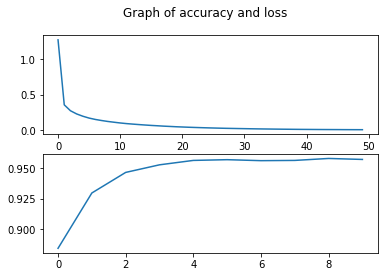

In [6]:
# Initialize my network
my_network = [28*28, 128, 10]
number_epochs = 50
# Initialize weights and biais of my_network
W, B = init_params(my_network)

# training
start_time = time.time()
losses = []
accuracies = []
for epoch in range(number_epochs):
    epoch_losses = np.array([])
    start_epoch_time = time.time()
    for i in range(len(train_labels)):
        # prepare the input image
        X = flatten(train_images[i])
        X = X.reshape(len(X), 1)
        Y = one_hot(train_labels[i])
        # forward-propagation
        Z, A = forward_pass(X, W, B)
        loss = categoricalCrossEntropy(A[-1], Y)
        epoch_losses = np.concatenate([epoch_losses, loss])
        # backpropagation
        dL_dW, dL_dB = [], []
        dL_dZ2 = A[-1] - Y
        dL_dW2 = np.dot(dL_dZ2, np.transpose(A[-2]))
        dL_dB2 = dL_dZ2
        dL_dW.append(dL_dW2)
        dL_dB.append(dL_dB2)
        
        dL_dA1 = np.dot(np.transpose(W[-1]), dL_dZ2)
        dA1_dZ1 = d_ReLU(Z[-2])
        dL_dZ1 = dL_dA1 * dA1_dZ1
        dL_dW1 = np.dot(dL_dZ1, np.transpose(X))
        dL_dB1 = dL_dZ1
        dL_dW.append(dL_dW1)
        dL_dB.append(dL_dB1)
        
        # update weights W and Biais B  
        dL_dW.reverse()
        dL_dB.reverse()
        W, B = update_W_and_B(W, dL_dW, B, dL_dB, 0.01)
    # Test my model at epoch = gama    
    if (epoch % 5 == 0):
        accuracy = compute_accuracy(val_images, val_labels, W, B)
        accuracies.append(accuracy)
        print('-------------------------------------------------------------------------> Accuracy : ',accuracies[-1])

    print('epoch ',epoch,' -------> loss : ',np.array(epoch_losses).mean(), ' | time : ',(time.time() - start_epoch_time))
    losses.append(np.array(epoch_losses).mean())

print("--- %s seconds ---" % (time.time() - start_time), ' | time : ',(time.time() - start_time)) 
fig, ax = plt.subplots(2)
fig.suptitle('Graph of accuracy and loss')
ax[0].plot(losses)
ax[1].plot(accuracies)

In [7]:
show_accuracies(train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B)

Accuracies :
    - train accuracy = 99.77833333333334 %
    - val accuracy = 95.86 %
    - test accuracy = 95.64 %
